# LRP and Grad-CAM on VGG16

In [2]:
#import custom utils
from shutil import copyfile
from utils import *
from matplotlib.colors import ListedColormap, Normalize
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def load_image(path):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    img = Image.open(path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0)
    return img_tensor, img

def get_model_layers():
    model = models.vgg16(pretrained=True)
    model.eval()
    layers = list(model._modules['features']) + [torch.nn.AdaptiveAvgPool2d((7, 7))] + toconv(list(model._modules['classifier']))
    return layers

def get_activations(layers, img_tensor):
    A = [img_tensor.clone().detach().requires_grad_(True)]
    for layer in layers:
        A.append(layer(A[-1]))
    return A

def get_relevance_scores(layers, activations, class_indx):
  L = len(layers)
  T = torch.FloatTensor((1.0*(np.arange(1000)==class_indx).reshape([1,1000,1,1])))
  R = [None]*L + [(activations[-1]*T).data]
  for l in range(1,L)[::-1]:
    activations[l] = (activations[l].data).requires_grad_(True)

    if isinstance(layers[l],torch.nn.MaxPool2d): layers[l] = torch.nn.AvgPool2d(2)

    if isinstance(layers[l],torch.nn.Conv2d) or isinstance(layers[l],torch.nn.AvgPool2d):

        if l <= 16:       rho = lambda p: p + 0.25*p.clamp(min=0); incr = lambda z: z+1e-9
        if 17 <= l <= 30: rho = lambda p: p;                       incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
        if l >= 31:       rho = lambda p: p;                       incr = lambda z: z+1e-9

        z = incr(newlayer(layers[l],rho).forward(activations[l]))  # step 1
        s = (R[l+1]/z).data                                        # step 2
        (z*s).sum().backward(); c = activations[l].grad            # step 3
        R[l] = (activations[l]*c).data                             # step 4

    elif isinstance(layers[l], torch.nn.AdaptiveAvgPool2d):
        # Reverse AdaptiveAvgPool2d by spreading relevance evenly
        shape = activations[l].shape
        R[l] = F.interpolate(R[l + 1], size=(shape[2], shape[3]), mode='bilinear', align_corners=False)

    else:

        R[l] = R[l+1]
  return R

def get_gradients(img_tensor, layers, activations, class_idx):
    output = activations[-1]
    one_hot = torch.zeros_like(output)
    one_hot[0, class_idx] = 1.0
    grads = [one_hot]
    for l in reversed(range(0, len(layers))):
      if isinstance(layers[l], torch.nn.ReLU):
        layers[l] = torch.nn.ReLU(inplace=False)
      # Detach and reattach to allow gradient flow only for this layer
      x = activations[l].clone().detach().requires_grad_(True)
      y = layers[l](x)

      gradient = grads[0]
      y.backward(gradient, retain_graph=True)
      grads.insert(0,x.grad)
    return grads

def get_grad_cam(grads, activations, layer_idx):
  grad = grads[layer_idx]
  act = activations[layer_idx]
  pooled_grads = grad.mean(dim=(2, 3), keepdim=True)
  cam = (pooled_grads * act).sum(dim=1).squeeze()

  cam = F.relu(cam.clone())
  cam = cam - cam.min()
  cam = cam / (cam.max() + 1e-8)

  return cam.detach().cpu().numpy()

def overlay(image_pil, cam, title='Grad-CAM'):
    cam_resized = Image.fromarray((cam * 255).astype(np.uint8)).resize(image_pil.size)
    cam_colored = plt.cm.jet(np.array(cam_resized)/255.0)[:, :, :3]
    image_np = np.array(image_pil)/255.0
    overlayed = 0.5 * image_np + 0.5 * cam_colored
    plt.imshow(overlayed)
    plt.title(title)
    plt.axis('off')
    plt.show()

def lrp_overlay(relevance_map, image_pil=None, alpha=0.5, title='LRP Overlay', overlay=False):
    if image_pil is not None:
      relevance_resized = Image.fromarray(relevance_map).resize(image_pil.size, resample=Image.BILINEAR)
      relevance_map = np.array(relevance_resized)

    b = 10 * (np.abs(relevance_map)**3.0).mean()**(1.0/3)
    R = np.clip(relevance_map, -b, b) / b

    base_cmap = plt.cm.seismic(np.linspace(0, 1, 256))
    base_cmap[:, :3] *= 0.85
    cmap = ListedColormap(base_cmap)

    R_color = cmap((R + 1) / 2)[:, :, :3]

    if image_pil is not None:
      image_np = np.array(image_pil).astype(np.float32) / 255.0
      blended = (1 - alpha) * image_np + alpha * R_color
      R_color = np.clip(blended, 0, 1)

    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(R_color)
    ax.axis('off')
    ax.set_title(title)
    norm = Normalize(vmin=-b, vmax=b)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Relevance', rotation=270, labelpad=15)
    plt.show()

###Change the input image here

In [5]:
# Change the image here
img_tensor, img = load_image("dog.jpg")
img_tensor = img_tensor.clone().detach().requires_grad_(True)
layers = get_model_layers()
act = get_activations(layers,img_tensor)
scores = np.array(act[-1].data.view(-1))
ind = np.argsort(-scores)
for i in ind[:10]:
    print('%20s (%3d): %6.3f'%(imgclasses[i][:20],i,scores[i]))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 81.0MB/s]


              kuvasz (222):  8.130
      Great Pyrenees (257):  7.240
white wolf, Arctic w (270):  6.118
ice bear, polar bear (296):  5.425
    golden retriever (207):  5.382
     Irish wolfhound (170):  5.320
Old English sheepdog (229):  5.193
   Eskimo dog, husky (248):  5.086
     standard poodle (267):  4.991
  Labrador retriever (208):  4.958


###Change the class and layer for RLP here

              kuvasz (222):  8.130


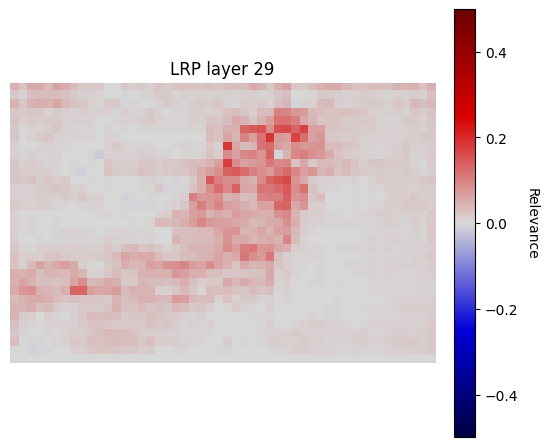

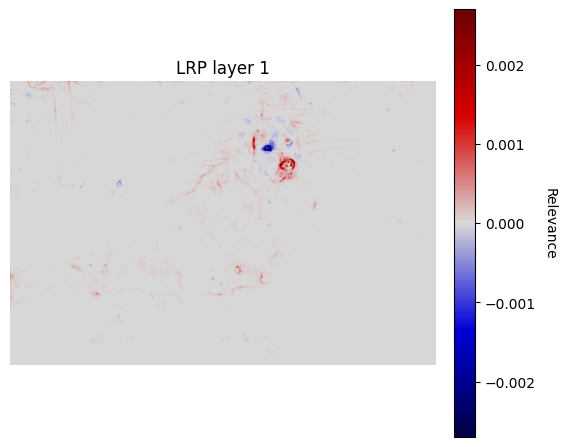

In [6]:
# idices of conv-layers in network
conv_indxs = [1, 3, 6, 8, 11, 13, 15, 18, 20, 22, 25, 27, 29, 33, 36, 39]
# adapt the number to apply to the class you want to visualise
chosen_class = 222
relevance_score_maps = get_relevance_scores(layers,act,chosen_class)
print('%20s (%3d): %6.3f'%(imgclasses[chosen_class][:20],chosen_class,scores[chosen_class]))

# adapt the array if you want to display other layers
for i,l in enumerate([29,1]):
    lrp_overlay(np.array(relevance_score_maps[l][0]).sum(axis=0), title='LRP layer '+str(l))

###Change the class and layer for Grad-CAM here

In [7]:
# Till layer 29 all are "real" conolutional layers after that they are nx1x1 conv
# layers so the Grad-Cam makes no sense with them
conv_indxs = [1, 3, 6, 8, 11, 13, 15, 18, 20, 22, 25, 27, 29, 33, 36, 39]
# Choose a class idx
chosen_class_grad = 222
print('%20s (%3d): %6.3f'%(imgclasses[chosen_class_grad][:20],chosen_class_grad,scores[chosen_class_grad]))
grads = get_gradients(img_tensor,layers,act,chosen_class_grad)

              kuvasz (222):  8.130


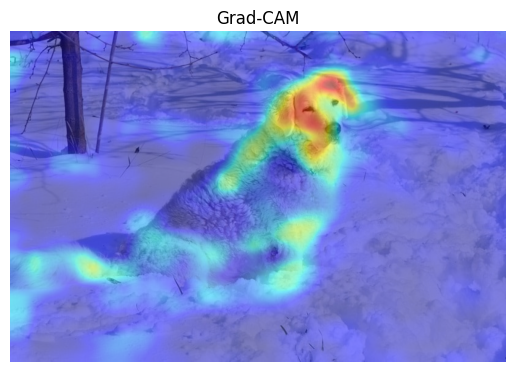

In [9]:
# Choose a layer that you want to display
chosen_layer_grad = 29
# The last "real" conv-layer is 29
map = get_grad_cam(grads,act,chosen_layer_grad)
overlay(img, map, title="Grad-CAM")